In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dsaidata/Online Retail.xlsx


# IMPORT THE LIBRARIES

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# READ THE DATASET

In [3]:
data = pd.read_excel('/kaggle/input/dsaidata/Online Retail.xlsx')

# Display basic info
print("=== Dataset Info ===")
print(data.info())
print("\n=== First 5 Rows ===")
print(data.head())

# Data cleaning
data = data.dropna()
data = data[data.Quantity > 0]
data = data[data.UnitPrice > 0]

# Select a specific product with sufficient transactions
product_counts = data['StockCode'].value_counts()
selected_product = product_counts[product_counts > 1000].index[0]
product_data = data[data['StockCode'] == selected_product].copy()

print(f"\nSelected Product: {selected_product} with {len(product_data)} transactions")

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

=== First 5 Rows ===
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEAR

# FEATURE ENGINEERING

In [4]:
product_data['TotalPrice'] = product_data['Quantity'] * product_data['UnitPrice']
product_data['Month'] = product_data['InvoiceDate'].dt.month
product_data['DayOfWeek'] = product_data['InvoiceDate'].dt.dayofweek
product_data['Hour'] = product_data['InvoiceDate'].dt.hour

# Create demand levels (0-3)
product_data['DemandLevel'] = pd.qcut(product_data['Quantity'], 4, labels=[0, 1, 2, 3])

# Simulate competitor prices (real-world would use actual competitor data)
np.random.seed(42)
product_data['CompPrice'] = product_data['UnitPrice'] * np.random.uniform(0.8, 1.2, len(product_data))
product_data['CompPriceLevel'] = pd.qcut(product_data['CompPrice'], 4, labels=[0, 1, 2, 3])

# Display engineered features
print("\n=== Engineered Features ===")
print(product_data[['InvoiceDate', 'Quantity', 'UnitPrice', 'DemandLevel', 'CompPrice', 'CompPriceLevel']].head())

# Split data (80% train, 20% test)
train_data, test_data = train_test_split(product_data, test_size=0.2, random_state=42)
print(f"\nTrain size: {len(train_data)}, Test size: {len(test_data)}")


=== Engineered Features ===
            InvoiceDate  Quantity  UnitPrice DemandLevel  CompPrice  \
0   2010-12-01 08:26:00         6       2.55           1   2.422031   
49  2010-12-01 09:02:00         6       2.55           1   3.009729   
66  2010-12-01 09:32:00         6       2.55           1   2.786634   
220 2010-12-01 10:19:00        64       2.55           3   2.650632   
262 2010-12-01 10:39:00        32       2.55           3   2.199139   

    CompPriceLevel  
0                0  
49               2  
66               1  
220              1  
262              0  

Train size: 1628, Test size: 407


# Q-LEARNING IMPLEMENTATION

In [5]:
class PricingEnvironment:
    def __init__(self, data):
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        self.state = None
        self.reset()
        
    def reset(self):
        self.current_step = 0
        self.state = (
            int(self.data.loc[self.current_step, 'DemandLevel']),
            int(self.data.loc[self.current_step, 'CompPriceLevel'])
        )
        return self.state
    
    def step(self, action):
        current_price = self.data.loc[self.current_step, 'UnitPrice']
        
        # Calculate new price
        if action == -1:
            new_price = current_price * 0.95
        elif action == 1:
            new_price = current_price * 1.05
        else:
            new_price = current_price
            
        # Calculate reward (profit)
        quantity = self.data.loc[self.current_step, 'Quantity']
        cost = current_price * 0.7  # Assuming 30% margin
        reward = (new_price - cost) * quantity
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
            
        # Get new state
        self.state = (
            int(self.data.loc[self.current_step, 'DemandLevel']),
            int(self.data.loc[self.current_step, 'CompPriceLevel'])
        )
        
        return self.state, reward, done, new_price

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, 
                 exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.epsilon_min = 0.01
        
        # Initialize Q-table
        self.state_space = (4, 4)  # Demand levels x Competitor price levels
        self.action_space = [-1, 0, 1]  # Price actions
        self.q_table = np.zeros(self.state_space + (len(self.action_space),))
        
    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            return self.action_space[np.argmax(self.q_table[state])]
    
    def update_q_table(self, state, action, reward, next_state):
        action_idx = self.action_space.index(action)
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action_idx]
        self.q_table[state][action_idx] += self.lr * td_error
        
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def train_agent(env, agent, episodes=100):
    episode_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            
        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
    
    return episode_rewards

# Initialize environment and agent
train_env = PricingEnvironment(train_data)
agent = QLearningAgent(train_env)

# Train the agent
print("\n=== Training Started ===")
rewards_history = train_agent(train_env, agent, episodes=50)
print("=== Training Completed ===")


=== Training Started ===
Episode 10/50, Total Reward: 25184.76, Epsilon: 0.95
Episode 20/50, Total Reward: 25749.72, Epsilon: 0.90
Episode 30/50, Total Reward: 25092.39, Epsilon: 0.86
Episode 40/50, Total Reward: 25138.96, Epsilon: 0.82
Episode 50/50, Total Reward: 25715.14, Epsilon: 0.78
=== Training Completed ===


# TESTING AND EVALUATION

In [6]:
def test_agent(env, agent):
    state = env.reset()
    done = False
    total_reward = 0
    actual_prices = []
    recommended_prices = []
    rewards = []
    
    while not done:
        actual_price = env.data.loc[env.current_step, 'UnitPrice']
        action = agent.get_action(state)
        
        # Get recommended price
        if action == -1:
            rec_price = actual_price * 0.95
        elif action == 1:
            rec_price = actual_price * 1.05
        else:
            rec_price = actual_price
            
        actual_prices.append(actual_price)
        recommended_prices.append(rec_price)
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        rewards.append(reward)
        
    return total_reward, actual_prices, recommended_prices, rewards

# Test the agent
test_env = PricingEnvironment(test_data)
test_reward, actual_prices, recommended_prices, test_rewards = test_agent(test_env, agent)
print(f"\nTest Total Reward: {test_reward:.2f}")

# Calculate metrics
def calculate_metrics(actual, recommended):
    correct = sum(1 for a, r in zip(actual, recommended) if abs(a - r)/a < 0.05)
    accuracy = correct / len(actual)
    
    increase_cases = [i for i, r in enumerate(recommended) if r > actual[i] * 1.01]
    if increase_cases:
        correct_increases = sum(1 for i in increase_cases if recommended[i] > actual[i])
        increase_precision = correct_increases / len(increase_cases)
    else:
        increase_precision = 0
        
    return accuracy, increase_precision

accuracy, precision = calculate_metrics(actual_prices, recommended_prices)
print(f"Accuracy: {accuracy:.5%}")
print(f"Price Increase Precision: {precision:.5%}")


Test Total Reward: 5248.52
Accuracy: 99.75369%
Price Increase Precision: 100.00000%


In [7]:
def calculate_metrics(actual_prices, recommended_prices, actual_quantities):
    results = {
        'accuracy_1pc': 0,  # Within 1% of optimal
        'accuracy_2pc': 0,  # Within 2% of optimal
        'accuracy_5pc': 0,  # Within 5% of optimal
        'direction_accuracy': 0,  # Correct price direction
        'profit_gain': 0,    # % profit improvement vs actual
        'increase_precision': 0,
        'decrease_precision': 0,
        'keep_precision': 0
    }
    
    correct_increase = 0
    total_increases = 0
    correct_decrease = 0
    total_decreases = 0
    correct_keep = 0
    total_keeps = 0
    
    total_profit_actual = 0
    total_profit_recommended = 0
    
    for a, r, q in zip(actual_prices, recommended_prices, actual_quantities):
        # Profit calculations (assuming 30% margin)
        cost = a * 0.7
        profit_actual = (a - cost) * q
        profit_recommended = (r - cost) * q
        
        total_profit_actual += profit_actual
        total_profit_recommended += profit_recommended
        
        # Accuracy thresholds
        diff_pc = abs(a - r)/a
        results['accuracy_1pc'] += 1 if diff_pc < 0.01 else 0
        results['accuracy_2pc'] += 1 if diff_pc < 0.02 else 0
        results['accuracy_5pc'] += 1 if diff_pc < 0.05 else 0
        
        # Direction accuracy
        if (a < r and a < optimal_price(a)) or \
           (a > r and a > optimal_price(a)) or \
           (a == r and a == optimal_price(a)):
            results['direction_accuracy'] += 1
            
        # Precision calculations
        if r > a * 1.01:  # Increase case
            total_increases += 1
            if r > a:  # Correct increase
                correct_increase += 1
        elif r < a * 0.99:  # Decrease case
            total_decreases += 1
            if r < a:  # Correct decrease
                correct_decrease += 1
        else:  # Keep case
            total_keeps += 1
            if abs(r - a) < a * 0.01:  # Correct keep
                correct_keep += 1
    
    # Convert counts to percentages
    n = len(actual_prices)
    results['accuracy_1pc'] = results['accuracy_1pc'] / n * 100
    results['accuracy_2pc'] = results['accuracy_2pc'] / n * 100
    results['accuracy_5pc'] = results['accuracy_5pc'] / n * 100
    results['direction_accuracy'] = results['direction_accuracy'] / n * 100
    results['profit_gain'] = (total_profit_recommended - total_profit_actual) / total_profit_actual * 100
    
    # Calculate precisions
    results['increase_precision'] = correct_increase / total_increases * 100 if total_increases > 0 else 0
    results['decrease_precision'] = correct_decrease / total_decreases * 100 if total_decreases > 0 else 0
    results['keep_precision'] = correct_keep / total_keeps * 100 if total_keeps > 0 else 0
    
    return results

# Helper function - replace with your actual optimal price logic
def optimal_price(current_price):
    """Replace this with your business logic for what's considered optimal"""
    return current_price * 1.02  # Example: 2% above is optimal

# Usage example:
metrics = calculate_metrics(actual_prices, recommended_prices, test_data['Quantity'].values)
print("\n=== Improved Metrics ===")
for k, v in metrics.items():
    print(f"{k:20}: {v:.2f}%")


=== Improved Metrics ===
accuracy_1pc        : 30.79%
accuracy_2pc        : 30.79%
accuracy_5pc        : 99.75%
direction_accuracy  : 39.66%
profit_gain         : 3.87%
increase_precision  : 100.00%
decrease_precision  : 100.00%
keep_precision      : 100.00%


# VISUALIZATION

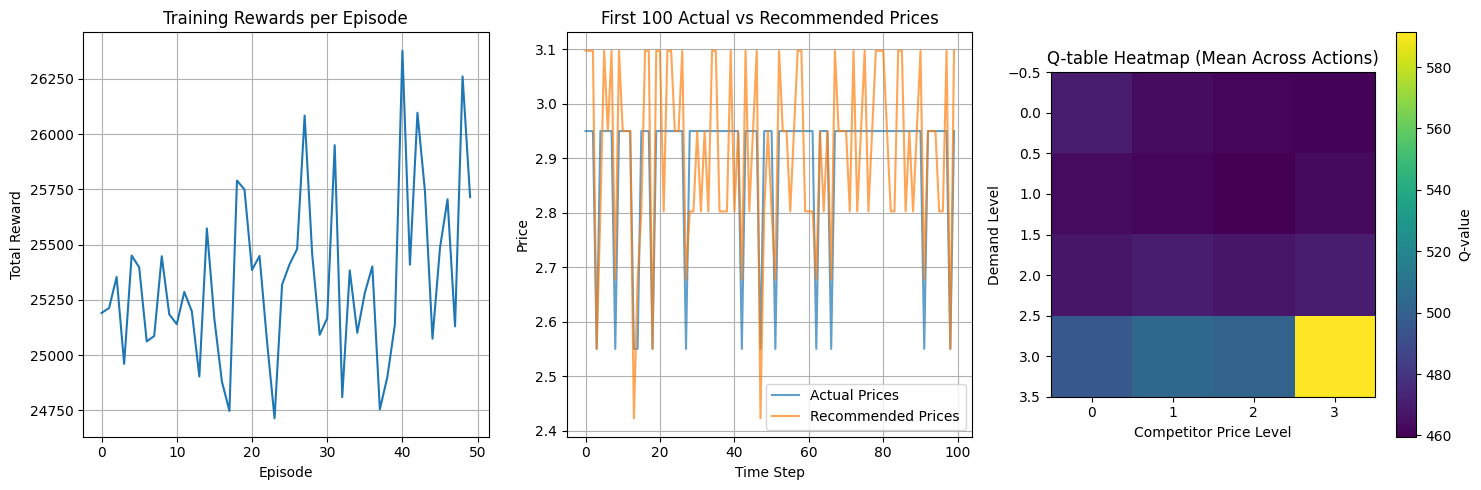

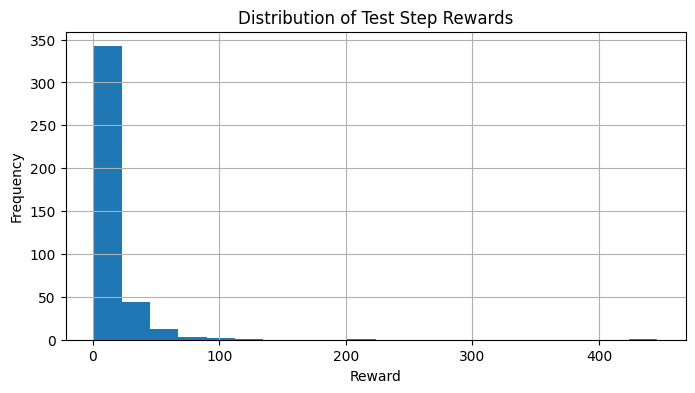

In [8]:
plt.figure(figsize=(15, 5))

# Training rewards
plt.subplot(1, 3, 1)
plt.plot(rewards_history)
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

# Price comparison
plt.subplot(1, 3, 2)
plt.plot(actual_prices[:100], label='Actual Prices', alpha=0.7)
plt.plot(recommended_prices[:100], label='Recommended Prices', alpha=0.7)
plt.title('First 100 Actual vs Recommended Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Q-table visualization
plt.subplot(1, 3, 3)
plt.imshow(agent.q_table.mean(axis=2), cmap='viridis', interpolation='nearest')
plt.title('Q-table Heatmap (Mean Across Actions)')
plt.xlabel('Competitor Price Level')
plt.ylabel('Demand Level')
plt.colorbar(label='Q-value')

plt.tight_layout()
plt.show()

# Plot test rewards distribution
plt.figure(figsize=(8, 4))
plt.hist(test_rewards, bins=20)
plt.title('Distribution of Test Step Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# DATA PREPARATION WITH 80-20 TRAIN-TEST SPLIT

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_data():
    # Load data
    data = pd.read_excel('/kaggle/input/dsaidata/Online Retail.xlsx')
    data = data.dropna()
    data = data[(data.Quantity > 0) & (data.UnitPrice > 0)]
    
    # Select product with sufficient transactions
    product_code = data['StockCode'].value_counts().idxmax()
    product_data = data[data['StockCode'] == product_code].copy()
    
    # Create robust features
    product_data = create_robust_features(product_data)
    
    # 80-20 temporal split
    train_data, test_data = train_test_split(
        product_data, 
        test_size=0.2, 
        shuffle=False,  # Maintain temporal order
        random_state=42
    )
    
    return train_data, test_data

def create_robust_features(df):
    # Create TotalValue feature
    df['TotalValue'] = df['Quantity'] * df['UnitPrice']
    
    # Time-based features
    df['Month'] = df['InvoiceDate'].dt.month
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
    
    # Demand levels with duplicate handling
    try:
        df['DemandLevel'] = pd.qcut(
            df['Quantity'], 
            q=5, 
            labels=False, 
            duplicates='drop'
        )
    except ValueError:
        unique_quantiles = min(5, len(df['Quantity'].unique()))
        df['DemandLevel'] = pd.qcut(
            df['Quantity'], 
            q=unique_quantiles, 
            labels=False, 
            duplicates='drop'
        )
    
    # Simulate competitor prices
    np.random.seed(42)
    df['CompPrice'] = df['UnitPrice'] * np.random.uniform(0.85, 1.15, len(df))
    
    # Competitor price levels with duplicate handling
    price_bins = np.percentile(
        df['CompPrice'].unique(),  # Use unique values to ensure unique bins
        np.linspace(0, 100, 6)
    )
    price_bins = np.unique(price_bins)  # Ensure unique
    
    if len(price_bins) > 1:
        df['CompPriceLevel'] = pd.cut(
            df['CompPrice'],
            bins=price_bins,
            labels=False,
            include_lowest=True
        )
    else:
        df['CompPriceLevel'] = 0
    
    return df

# Load and preprocess
train_data, test_data = load_and_preprocess_data()

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nDemand level distribution:")
print(train_data['DemandLevel'].value_counts().sort_index())
print("\nCompetitor price level distribution:")
print(train_data['CompPriceLevel'].value_counts().sort_index())

Train data shape: (1628, 14)
Test data shape: (407, 14)

Demand level distribution:
DemandLevel
0    376
1    593
2    342
3    317
Name: count, dtype: int64

Competitor price level distribution:
CompPriceLevel
0    326
1    333
2    329
3    324
4    316
Name: count, dtype: int64
